# Grupo

Lélio Marcos Rangel Cunha - 13673148

Victor Hugo Trigolo Amaral - 12688487

Lucas Issao Omati - 13673090

João Pedro Buzzo Silva - 10425191

Nicholas Yudi Kurita Ikai - 13671852

# Descrição do Problema

O presente trabalho visa desenvolver um sistema de inteligência artificial para a detecção e classificação de gases, um problema de grande relevância para a segurança industrial, monitoramento da qualidade do ar e automação residencial. A capacidade de identificar a presença e o tipo de gás em um ambiente é crucial para prevenir acidentes, como intoxicações ou explosões, e para acionar sistemas de alerta ou ventilação.

O objetivo específico desta etapa é construir e treinar um modelo de rede neural convolucional (CNN) capaz de classificar um ambiente em uma de quatro categorias (sem gás, perfume, fumaça ou uma mistura dos dois) apenas com base em sua imagem térmica. A hipótese é que as diferentes condições geram assinaturas térmicas distintas – seja pela dispersão de partículas ou por variações de temperatura – que podem ser capturadas e aprendidas por um modelo de visão computacional.

Para resolver este problema de classificação de imagens, foi utilizada a técnica de Aprendizagem por Transferência (Transfer Learning). Selecionamos o modelo MobileNetV3 Small, pré-treinado na base de dados ImageNet. A estratégia consiste em congelar os pesos das camadas convolucionais (que são excelentes extratores de características visuais) e treinar apenas uma nova camada de classificação, adaptada para as classes específicas do nosso problema.

# Conjunto de Dados Utilizado

Para este estudo, utilizamos o dataset público "MultimodalGasData: Multimodal Dataset for Gas Detection and Classification".

Citação:
> Narkhede, Parag; Walambe, Rahee ; Chandel, Pulkit; Mandaokar, Shruti; Kotecha, Ketan (2022), “MultimodalGasData: Multimodal Dataset for Gas Detection and Classification”, Mendeley Data, V2, doi: 10.17632/zkwgkjkjn9.2

Este conjunto de dados é inerentemente multimodal, contendo medições simultâneas de sete sensores de gás de óxido de metal (MQ2, MQ3, MQ5, MQ6, MQ7, MQ8, MQ135) e imagens de uma câmera térmica. No entanto, para os fins desta primeira entrega, utilizamos exclusivamente o subconjunto de imagens térmicas.

- Estrutura e Classes: O dataset está dividido em quatro classes distintas, que representam os cenários a serem classificados:
  - No Gas (Ausência de gás)
  - Perfume (Presença de perfume)
  - Smoke (Presença de fumaça)
  - Mixture (Mistura de perfume e fumaça)

  O código carrega as imagens de seus respectivos diretórios, usando os nomes dos diretórios como rótulos para o treinamento.

- Pré-processamento: Antes de serem enviadas para a rede neural, as imagens passam por uma série de transformações:
  - Redimensionamento: Todas as imagens são redimensionadas para 224x224 pixels, o que padroniza a entrada para o modelo MobileNetV3.
  - Conversão para Tensor: As imagens são convertidas para o formato de tensores do PyTorch.
  - Normalização: Os valores dos pixels são normalizados para terem uma média de 0.5 e um desvio padrão de 0.5. Este passo é fundamental para garantir um treinamento estável e eficiente.

- Divisão dos Dados: Para treinar e avaliar o modelo de forma robusta, o conjunto de dados foi dividido em três subconjuntos:
  - Treinamento (70%): Utilizado para o ajuste dos pesos da camada de classificação do modelo.
  - Validação (15%): Usado durante o treinamento para monitorar o desempenho, evitar overfitting e salvar o melhor modelo.
  - Teste (15%): Reservado para a avaliação final do modelo, fornecendo uma métrica imparcial de sua capacidade de generalização em dados nunca vistos.

# Prática 1

In [1]:
import imageio.v3 as iio
import os
import numpy as np
import matplotlib.pyplot as plt

## Carregando as imagens

In [2]:
import pandas as pd
from PIL import Image

# Define o caminho para a pasta raiz que contém os subdiretórios de cada classe.
image_paths = "./dados/Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images"
# Inicializa um DataFrame pandas vazio que irá armazenar os resultados.
df_images = pd.DataFrame()

# Itera sobre cada subdiretório (que representa uma classe/rótulo).
for label in os.listdir(image_paths):
    # Itera sobre cada arquivo dentro do subdiretório da classe.
    for image in os.listdir(f"{image_paths}/{label}"):
        # Filtra para processar apenas arquivos de imagem com a extensão .png.
        if not image.endswith(".png"):
            continue

        # Cria uma nova linha para o DataFrame, associando o nome do arquivo ao seu rótulo.
        new_row = pd.DataFrame([{
            "path": image,
            "label": label
        }])
        # Adiciona a nova linha ao DataFrame principal. `reset_index` mantém o índice contínuo.
        df_images = pd.concat([df_images, new_row]).reset_index(drop=True)

df_images.to_csv("images.csv", index=False)


In [3]:
df_images["path"].count()

np.int64(6400)

Text(0.5, 1.0, 'Distribuição das labels na base de dados.')

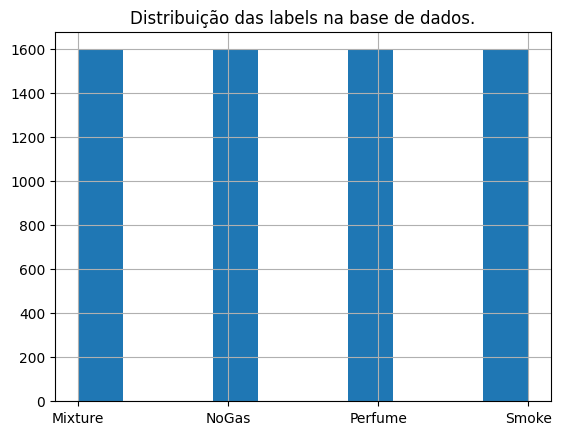

In [4]:
# Histograma para visualizarmos o balanceamento das classes.
df_images["label"].hist()
plt.title("Distribuição das labels na base de dados.")

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torch.utils.data import Dataset

## Criando o dataset

In [6]:
# Diretório raiz onde as subpastas de cada classe estão localizadas.
image_paths = "./dados/Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images"

# Define uma classe de Dataset customizada para carregar as imagens e rótulos.
class SmokeDetectorImageDataset(Dataset):
    # Inicializa o dataset, carregando os dados e definindo as transformações.
    def __init__(self, img_dirs, annotations_file, transform=None, target_transform=None):
        # Carrega o arquivo CSV que mapeia imagens para rótulos.
        self.imgs = pd.read_csv(annotations_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.target_transform = target_transform
        # Cria uma lista ordenada de rótulos para um mapeamento consistente de string para inteiro.
        self.labels = sorted(os.listdir(self.img_dirs))

    # Retorna o número total de amostras no dataset.
    def __len__(self):
        return len(self.imgs)

    # Busca e retorna uma amostra (imagem, rótulo) do dataset dado um índice `idx`.
    def __getitem__(self, idx):
        # Obtém o nome do arquivo da imagem e o nome da classe do DataFrame.
        img_path = self.imgs.iloc[idx, 0]
        label = self.labels.index(self.imgs.iloc[idx, 1])

        # Constrói o caminho completo do arquivo e carrega a imagem.
        image = decode_image(os.path.join(f"{self.img_dirs}/{self.labels[label]}",img_path), mode="RGB")

        # Aplica transformações à imagem, se houver.
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [7]:
# Define a sequência de pré-processamento (data augmentation/normalization) para as imagens.
transform = transforms.Compose(

    [transforms.ToPILImage(),
      # 1. Padroniza o tamanho de todas as imagens para 224x224 pixels.
      transforms.Resize((224, 224)),
      # 2. Converte a imagem para um tensor PyTorch, escalando pixels para o intervalo [0, 1].
      transforms.ToTensor(),
      # 3. Normaliza o tensor, ajustando os valores dos pixels para o intervalo [-1, 1].
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
# Instancia o dataset completo, aplicando as transformações definidas anteriormente.
full_images = SmokeDetectorImageDataset(image_paths, "images.csv", transform)

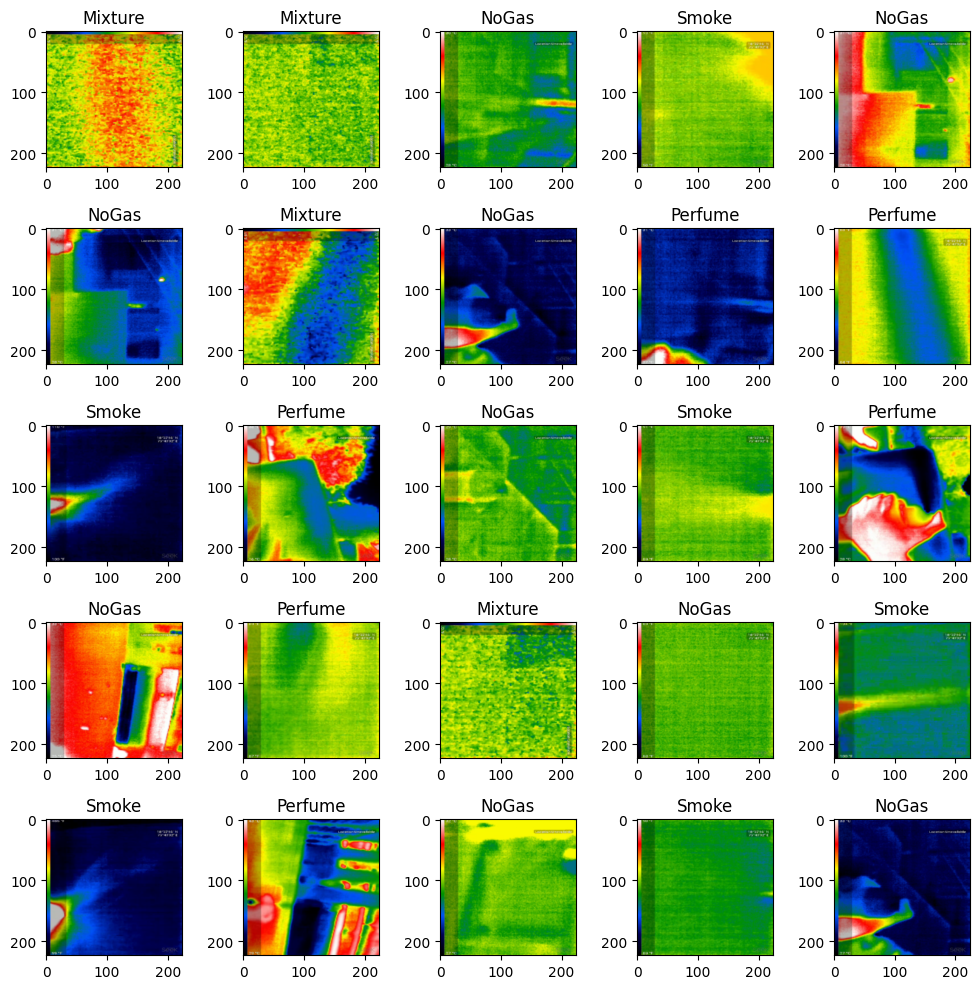

In [9]:
from random import randint

# Grade de visualização (5x5).
n = 5

fig, ax = plt.subplots(n, n, figsize=(10, 10))

# Itera para preencher cada um dos 25 subplots da grade.
for i in range(n*n):
  # Escolhe um índice aleatório para selecionar uma imagem do dataset.
  i_random = randint(0, len(full_images))

  # Obtém a imagem e reverte a normalização (de [-1,1] para [0,1]) para visualização.
  img = full_images[i_random][0] / 2 + 0.5
  npimg = img.numpy()

  # Calcula a posição (linha, coluna) e exibe a imagem no subplot correspondente.
  # np.transpose muda o formato de (C, H, W) para (H, W, C) que o matplotlib espera.
  ax[i // n, i % n].imshow(np.transpose(npimg, (1, 2, 0)))
  ax[i // n, i % n].set_title(full_images.labels[full_images[i_random][1]])

fig.tight_layout()
plt.show()

In [10]:
# Carregando o dispositivo.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Criando o modelo

Estamos utilizando o modelo [MobileNet V3 Small](https://arxiv.org/abs/1905.02244). Alteraremos a ultima camada para classificar entre as 5 categorias da nossa base.

In [11]:
import torchvision.models as models

# Carregando modelo.
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT).to(device)

# Desligando o Gradient para todas as camadas.
for param in model.parameters():
    param.requires_grad = False

# Modifica a última camada para classificar em 5 classes.
in_features = model.classifier[-1].in_features
num_classes = 4
new_classifier = torch.nn.Linear(in_features, num_classes)

model.classifier[-1] = new_classifier

In [12]:
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [13]:
# Divide o dataset completo em três subconjuntos aleatórios e não sobrepostos.
# A divisão segue as proporções definidas: 70% para treino, 15% para validação e 15% para teste.
torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_images, [0.70, 0.15, 0.15])

In [14]:
from torch.utils.data import DataLoader

# Cria um dicionário de DataLoaders para carregar os dados em lotes (batches).
dataloaders = {
    # `shuffle=True`: embaralha os dados a cada época para melhorar a generalização do modelo.
    # `num_workers`: acelera o carregamento de dados usando processos paralelos.
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0),
    "val": DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0),
    "test": DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0),
}

In [15]:
import time
from tempfile import TemporaryDirectory

# Pré-calcula os tamanhos dos datasets para uso no cálculo das métricas.
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

# Define a função principal para treinar e validar o modelo.
def train_model(model, criterion, device, optimizer, num_epochs=25):
    # Estratégia: a função itera por épocas. Em cada época, realiza uma fase de
    # treinamento e uma de validação. A acurácia da validação é usada para
    # rastrear o melhor modelo, que é salvo e carregado ao final.


    since = time.time()

    best_acc = 0.0
    accuracys = {
        "train": [],
        "val": []
    }

    # Usa um diretório temporário para salvar o melhor modelo, garantindo a limpeza automática.
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Alterna entre a fase de treinamento e a de validação.
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Muda estado do modelo para treinamento
                else:
                    model.eval()   # Muda estado do modelo para validação

                running_loss = 0.0
                running_corrects = 0
                loss = None
                preds = []

                # Itera sobre os lotes (batches) de dados.
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()  # Limpa os gradientes da iteração anterior.

                    # Habilita o cálculo de gradientes apenas na fase de treino para otimizar.
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)   # Obtém a classe predita.
                        loss = criterion(outputs, labels)

                        # Se for a fase de treino, executa o backpropagation e atualiza os pesos.
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Acumula as métricas de loss e acertos do batch.
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Calcula e armazena a loss e acurácia médias da época.
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                accuracys[phase].append(epoch_acc)  # Salva a acurácia da época

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Salva o modelo apenas se a acurácia de validação melhorar.
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Carrega os pesos do melhor modelo encontrado durante a validação.
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    # Retorna o modelo treinado com os melhores pesos e o histórico de acurácia.
    return model, accuracys


In [16]:
# Define a função de perda (loss function).
criterion = torch.nn.CrossEntropyLoss()

# Define o otimizador. Adam é um algoritmo que ajusta os pesos do modelo para minimizar a perda.
# `lr=0.001` é a taxa de aprendizado (learning rate).
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Inicia o processo de treinamento do modelo por 50 épocas.
# A função retorna o modelo treinado (com os melhores pesos de validação)
# e o histórico de acurácia para análise.
model, accuracys = train_model(model, criterion, device, optimizer_ft, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.5086 Acc: 0.8268
val Loss: 0.4240 Acc: 0.8542

Epoch 2/50
----------
train Loss: 0.2730 Acc: 0.9051
val Loss: 0.2725 Acc: 0.9073

Epoch 3/50
----------
train Loss: 0.2314 Acc: 0.9163
val Loss: 0.2033 Acc: 0.9271

Epoch 4/50
----------
train Loss: 0.2044 Acc: 0.9286
val Loss: 0.1685 Acc: 0.9437

Epoch 5/50
----------
train Loss: 0.1886 Acc: 0.9330
val Loss: 0.1596 Acc: 0.9500

Epoch 6/50
----------
train Loss: 0.1858 Acc: 0.9346
val Loss: 0.1474 Acc: 0.9552

Epoch 7/50
----------
train Loss: 0.1656 Acc: 0.9384
val Loss: 0.1500 Acc: 0.9448

Epoch 8/50
----------
train Loss: 0.1607 Acc: 0.9449
val Loss: 0.1390 Acc: 0.9552

Epoch 9/50
----------
train Loss: 0.1570 Acc: 0.9435
val Loss: 0.1394 Acc: 0.9490

Epoch 10/50
----------
train Loss: 0.1515 Acc: 0.9449
val Loss: 0.1323 Acc: 0.9500

Epoch 11/50
----------
train Loss: 0.1496 Acc: 0.9449
val Loss: 0.1304 Acc: 0.9542

Epoch 12/50
----------
train Loss: 0.1367 Acc: 0.9507
val Loss: 0.1264 Acc: 0.9542

E

Melhor acurácia: 96%

AVALIAÇÃO VISUAL DO TREINAMENTO

A estratégia é plotar as curvas de acurácia para diagnosticar o comportamento do modelo,
como a velocidade de aprendizado e a ocorrência de overfitting.

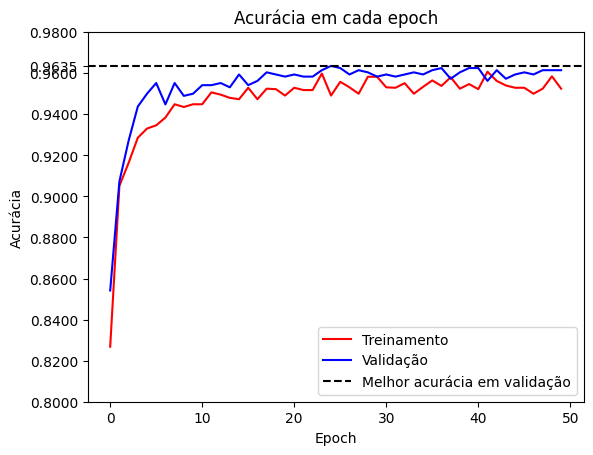

In [18]:
# Obtém a maior acurácia alcançada no conjunto de validação.
best = max(accuracys["val"])

plt.title("Acurácia em cada epoch")
# Plota a curva de acurácia de TREINAMENTO (em vermelho).
plt.plot(accuracys["train"], c='r', label="Treinamento")
# Plota a curva de acurácia de VALIDAÇÃO (em azul) para avaliar a generalização.
plt.plot(accuracys["val"], c='b', label="Validação")
# Adiciona uma linha de referência para destacar a melhor performance alcançada.
plt.axhline(y=best, label='Melhor acurácia em validação', ls='--', c="black")

# Garante que o valor exato da melhor acurácia seja exibido como um marcador no eixo Y.
yticks = list(plt.yticks())[0].tolist() + [best]
plt.yticks(yticks)

plt.xlabel("Epoch")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

## Testando

AVALIAÇÃO DO MODELO EM DADOS DE TESTE

Estratégia: Obter um lote (batch) do conjunto de teste para fazer previsões e compará-las com os rótulos verdadeiros.

In [19]:
# Cria um iterador para o DataLoader de teste, permitindo buscar um lote de dados.
dataiter = iter(dataloaders["test"])

# Extrai o próximo lote (um batch de imagens e seus rótulos) do iterador.
images, labels = next(dataiter)

# Converte os rótulos numéricos do lote para seus nomes em texto (ex: 2 -> 'Smoke') e os exibe como "GroundTruth".
print(f'GroundTruth: {[full_images.labels[labels[j]] for j in range(len(labels))]}')

GroundTruth: ['NoGas', 'Smoke', 'Perfume', 'NoGas', 'NoGas', 'Smoke', 'Smoke', 'Perfume', 'Smoke', 'Smoke', 'Mixture', 'Perfume', 'Mixture', 'Smoke', 'Smoke', 'Smoke', 'Smoke', 'Perfume', 'NoGas', 'NoGas', 'Smoke', 'NoGas', 'Smoke', 'NoGas', 'NoGas', 'Smoke', 'Smoke', 'NoGas', 'NoGas', 'Smoke', 'Perfume', 'NoGas']


In [20]:
# Passa o lote de imagens de teste pelo modelo para obter as previsões.
outputs = model(images)

# Extrai a classe com a maior pontuação como a predição final para cada imagem.
_, preds = torch.max(outputs, 1)


print(f'Predicted: {[full_images.labels[preds[j]] for j in range(len(labels))]}')
print(f"Accuracy: {torch.sum(labels.data == preds)/len(labels)}")

Predicted: ['NoGas', 'Smoke', 'Perfume', 'NoGas', 'NoGas', 'Smoke', 'Smoke', 'Perfume', 'Smoke', 'Smoke', 'Mixture', 'NoGas', 'Mixture', 'Smoke', 'Smoke', 'Smoke', 'Smoke', 'Perfume', 'NoGas', 'NoGas', 'Smoke', 'NoGas', 'Smoke', 'Perfume', 'NoGas', 'Smoke', 'Smoke', 'NoGas', 'NoGas', 'Smoke', 'Perfume', 'Perfume']
Accuracy: 0.90625


Visualizando as imagens que o modelo classificou incorretamente

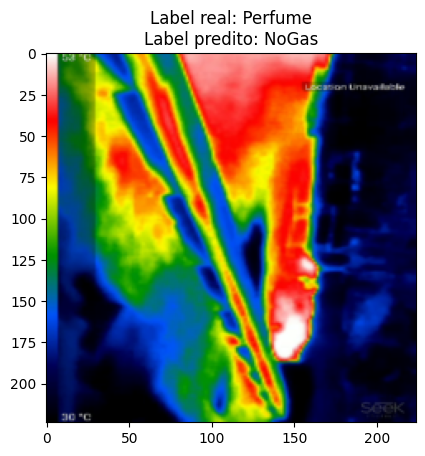

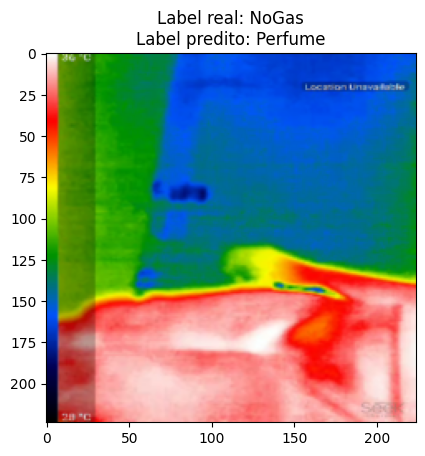

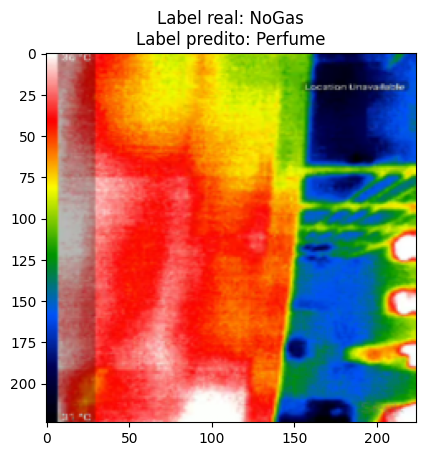

In [21]:
# Itera sobre os resultados do lote de teste.
for i in range(len(labels)):
    # Filtra apenas os casos em que a predição foi incorreta.
    if labels[i] != preds[i]:
        # Desnormaliza a imagem para restaurar as cores originais para visualização.
        img = images[i] / 2 + 0.5
        npimg = img.numpy()

        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        # Define um título claro que mostra a discrepância entre o real e o predito.
        plt.title(f"Label real: {full_images.labels[labels[i]]}\nLabel predito: {full_images.labels[preds[i]]}")
        plt.show()

In [22]:
csv_path = "./dados/Multimodal Dataset for Gas Detection and Classification/Gas Sensors Measurements/Gas_Sensors_Measurements.csv"
df_sensors = pd.read_csv(csv_path)
df_sensors.head()

,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,Corresponding Image Name
0,0,555,515,377,338,666,451,416,NoGas,0_NoGas
1,1,555,516,377,339,666,451,416,NoGas,1_NoGas
2,2,556,517,376,337,666,451,416,NoGas,2_NoGas
3,3,556,516,376,336,665,451,416,NoGas,3_NoGas
4,4,556,516,376,337,665,451,416,NoGas,4_NoGas


In [23]:
class GasSensorDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.labels = sorted(self.df["Gas"].unique())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sensor = torch.tensor([
            row["MQ2"], row["MQ3"], row["MQ5"], row["MQ6"],
            row["MQ7"], row["MQ8"], row["MQ135"]
        ], dtype=torch.float32)

        label = self.labels.index(row["Gas"])
        return sensor, label


In [24]:
class SensorMLP(torch.nn.Module):
    def __init__(self, input_size=7, hidden_size=32, num_classes=4):
        super(SensorMLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [25]:
gas_sensor_dataset = GasSensorDataset(csv_path)

Text(0.5, 1.0, 'Distribuição das labels na base de dados.')

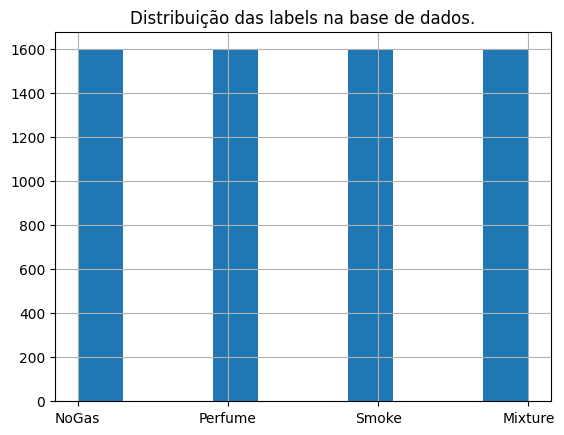

In [26]:
# Histograma para visualizarmos o balanceamento das classes.
gas_sensor_dataset.df["Gas"].hist()
plt.title("Distribuição das labels na base de dados.")


In [27]:
total_len = len(gas_sensor_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

torch.manual_seed(42)


train_sensor_dataset, val_sensor_dataset, test_sensor_dataset = torch.utils.data.random_split(
    gas_sensor_dataset, [train_len, val_len, test_len])

sensor_dataloaders = {
    "train": DataLoader(train_sensor_dataset, batch_size=32, shuffle=True),
    "val": DataLoader(val_sensor_dataset, batch_size=32, shuffle=True),
    "test": DataLoader(test_sensor_dataset, batch_size=32, shuffle=True),
}

sensor_dataset_sizes = {
    "train": len(train_sensor_dataset),
    "val": len(val_sensor_dataset)
}

In [28]:
def train_sensor_model(model, criterion, device, optimizer, num_epochs=25, dataloaders=None, dataset_sizes=None):
    since = time.time()
    best_acc = 0.0
    accuracys = {
        "train": [],
        "val": []
    }

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                accuracys[phase].append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, accuracys

In [29]:
model_mlp = SensorMLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)


model_mlp, accuracys = train_sensor_model(
    model_mlp, criterion, device, optimizer, num_epochs=50,
    dataloaders=sensor_dataloaders,
    dataset_sizes=sensor_dataset_sizes
)


Epoch 1/50
----------
train Loss: 13.4984 Acc: 0.2944
val Loss: 2.6625 Acc: 0.5687

Epoch 2/50
----------
train Loss: 1.7948 Acc: 0.6556
val Loss: 1.3956 Acc: 0.6292

Epoch 3/50
----------
train Loss: 0.8896 Acc: 0.7312
val Loss: 0.6234 Acc: 0.7250

Epoch 4/50
----------
train Loss: 0.6434 Acc: 0.7433
val Loss: 0.3917 Acc: 0.8417

Epoch 5/50
----------
train Loss: 0.5119 Acc: 0.7683
val Loss: 0.5742 Acc: 0.7250

Epoch 6/50
----------
train Loss: 0.5737 Acc: 0.7701
val Loss: 0.3304 Acc: 0.8427

Epoch 7/50
----------
train Loss: 0.6760 Acc: 0.7712
val Loss: 0.4890 Acc: 0.7781

Epoch 8/50
----------
train Loss: 0.4355 Acc: 0.8058
val Loss: 0.5313 Acc: 0.7312

Epoch 9/50
----------
train Loss: 0.4211 Acc: 0.7920
val Loss: 0.3939 Acc: 0.7802

Epoch 10/50
----------
train Loss: 0.5492 Acc: 0.7895
val Loss: 1.0063 Acc: 0.7302

Epoch 11/50
----------
train Loss: 0.5427 Acc: 0.7855
val Loss: 0.3241 Acc: 0.8302

Epoch 12/50
----------
train Loss: 0.4998 Acc: 0.8038
val Loss: 0.3133 Acc: 0.8531



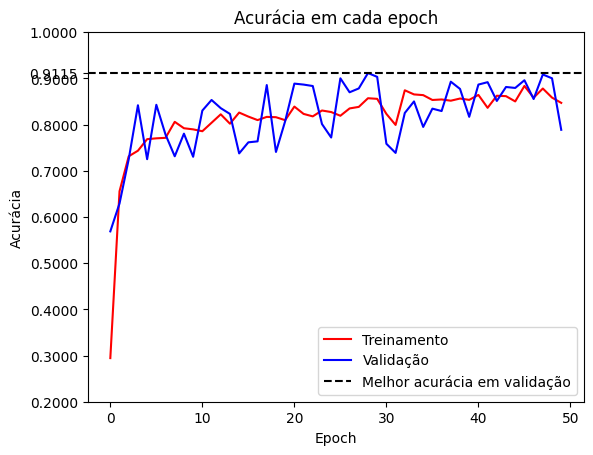

In [30]:
# Obtém a maior acurácia alcançada no conjunto de validação.
best = max(accuracys["val"])

plt.title("Acurácia em cada epoch")
# Plota a curva de acurácia de TREINAMENTO (em vermelho).
plt.plot(accuracys["train"], c='r', label="Treinamento")
# Plota a curva de acurácia de VALIDAÇÃO (em azul) para avaliar a generalização.
plt.plot(accuracys["val"], c='b', label="Validação")
# Adiciona uma linha de referência para destacar a melhor performance alcançada.
plt.axhline(y=best, label='Melhor acurácia em validação', ls='--', c="black")

# Garante que o valor exato da melhor acurácia seja exibido como um marcador no eixo Y.
yticks = list(plt.yticks())[0].tolist() + [best]
plt.yticks(yticks)

plt.xlabel("Epoch")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

# Fusão Multimodal

Nesta etapa, vamos combinar os dois modelos treinados anteriormente para criar um classificador multimodal mais robusto. A estratégia é usar cada modelo treinado como um "extrator de características" fixo e treinar apenas uma nova camada de fusão que aprende a combinar essas características.

In [31]:
import pandas as pd

In [32]:
# Carrega os DataFrames
df_images_check = pd.read_csv("images.csv")
sensor_data_path_check = "./dados/Multimodal Dataset for Gas Detection and Classification/Gas Sensors Measurements/Gas_Sensors_Measurements.csv"
df_sensors_check = pd.read_csv(sensor_data_path_check)
df_sensors_check.rename(columns={"Corresponding Image Name": "path"}, inplace=True)

# Imprime os 5 primeiros valores da coluna 'path' de cada um
print("--- Amostras da coluna 'path' em df_images ---")
print(df_images_check['path'].head())
print("\n" + "="*50 + "\n")
print("--- Amostras da coluna 'path' em df_sensors ---")
print(df_sensors_check['path'].head())

--- Amostras da coluna 'path' em df_images ---
0       0_Mixture.png
1    1000_Mixture.png
2    1001_Mixture.png
3    1002_Mixture.png
4    1003_Mixture.png
Name: path, dtype: object


--- Amostras da coluna 'path' em df_sensors ---
0    0_NoGas
1    1_NoGas
2    2_NoGas
3    3_NoGas
4    4_NoGas
Name: path, dtype: object


In [33]:
from sklearn.preprocessing import StandardScaler

# Carrega os metadados
df_images = pd.read_csv("images.csv")
sensor_data_path = "./dados/Multimodal Dataset for Gas Detection and Classification/Gas Sensors Measurements/Gas_Sensors_Measurements.csv"
df_sensors = pd.read_csv(sensor_data_path)


# Prepara as colunas para a união
# Renomeia a coluna chave no df_sensors para um nome temporário, para evitar conflitos.
df_sensors.rename(columns={"Corresponding Image Name": "merge_key"}, inplace=True)

# Cria uma nova coluna em df_images que será a nossa chave de união,
# removendo a extensão '.png' da coluna 'path'.
df_images['merge_key'] = df_images['path'].str.replace('.png', '', regex=False)

# Uni os DataFrames usando a nova coluna 'merge_key'
df_multimodal = pd.merge(df_images, df_sensors, on="merge_key")

# Checagem de segurança para ver se o merge funcionou
if df_multimodal.empty:
    print("ERRO: O DataFrame ainda está vazio após o merge. Verifique se a remoção de '.png' foi suficiente.")
else:
    print(f"SUCESSO: O merge encontrou {len(df_multimodal)} correspondências!")

    # Normaliza os dados dos sensores
    sensor_columns = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
    scaler = StandardScaler()
    df_multimodal[sensor_columns] = scaler.fit_transform(df_multimodal[sensor_columns].values)

    print("\nDataFrame multimodal unificado e normalizado pronto!")
    display(df_multimodal.head())

SUCESSO: O merge encontrou 6400 correspondências!

DataFrame multimodal unificado e normalizado pronto!


,path,label,merge_key,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas
0,0_Mixture.png,Mixture,0_Mixture,0,-1.846944,-0.996388,-1.088223,-1.968574,-2.056511,-2.122224,-1.496269,Mixture
1,1000_Mixture.png,Mixture,1000_Mixture,1000,-0.630670,-0.654890,0.582399,0.338035,-0.384375,-1.142147,0.290484,Mixture
2,1001_Mixture.png,Mixture,1001_Mixture,1001,-0.662960,-0.654890,0.600363,0.471108,-0.240018,-0.910371,0.277442,Mixture
3,1002_Mixture.png,Mixture,1002_Mixture,1002,-0.652197,-0.654890,0.474617,0.382393,-0.264078,-0.705085,0.329610,Mixture
4,1003_Mixture.png,Mixture,1003_Mixture,1003,-0.501508,-0.640660,0.582399,0.426750,-0.528732,-0.830906,0.303526,Mixture


In [44]:
# O nome do arquivo problemático que encontramos no erro
problematic_filename = "1123_NoGas.png"

print(f"Número de amostras multimodais antes da limpeza: {len(df_multimodal)}")

# Remove a linha correspondente a esse arquivo do DataFrame multimodal
# Usamos a coluna 'path', que contém o nome do arquivo com a extensão .png
df_multimodal_clean = df_multimodal[df_multimodal['path'] != problematic_filename].copy()

print(f"Número de amostras multimodais após a limpeza: {len(df_multimodal_clean)}")

Número de amostras multimodais antes da limpeza: 6400
Número de amostras multimodais após a limpeza: 6399


In [46]:
class MultimodalGasDataset(Dataset):
    def __init__(self, dataframe, img_root_dir, sensor_cols, transform=None):
        self.df = dataframe
        self.img_root_dir = img_root_dir
        self.sensor_cols = sensor_cols
        self.transform = transform
        self.labels_map = sorted(self.df['label'].unique())
        self.label_to_int = {label: i for i, label in enumerate(self.labels_map)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- Carrega a Imagem ---
        img_filename = row['path'] # ex: "1101_NoGas.png"
        label_name = row['label']    # ex: "NoGas"
        label = self.label_to_int[label_name]
        
        # Constrói o caminho completo
        full_image_path = os.path.join(self.img_root_dir, label_name, img_filename)
        
        # Usa a biblioteca PIL (Image) para abrir a imagem, que é mais robusta,
        # e depois a conversão para RGB garante consistência de canais.
        try:
            image = Image.open(full_image_path).convert("RGB")
        except Exception as e:
            print(f"ERRO ao carregar com PIL no índice {idx}, path: {full_image_path}")
            raise e

        # Aplica as transformações (que já incluem ToTensor)
        if self.transform:
            image = self.transform(image)
        # -----------------------------------------------
            
        # --- Carrega os Dados do Sensor ---
        sensor_array = np.array(row[self.sensor_cols].values, dtype=np.float32)
        sensor_values = torch.from_numpy(sensor_array)
        
        return image, sensor_values, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
import torch.nn as nn

# Prepara os modelos individuais especialistas

# Especialista de Imagem: está salvo de forma clara na variável 'model'
image_expert = model
# Coloca em modo de avaliação e remove a cabeça de classificação
num_image_features = image_expert.classifier[-1].in_features
image_expert.classifier[-1] = nn.Identity()
image_expert.eval()

# Especialista de Sensores: está salvo na sua nova variável 'model_mlp'
sensor_expert = model_mlp
# Coloca em modo de avaliação e remove a cabeça de classificação
num_sensor_features = sensor_expert.net[-1].in_features
sensor_expert.net = nn.Sequential(*list(sensor_expert.net.children())[:-1])
sensor_expert.eval()

print(f"Especialista de imagem pronto. Saída de características: {num_image_features}")
print(f"Especialista de sensores pronto. Saída de características: {num_sensor_features}")

# Construir o Modelo de Fusão:

class FusionModel(nn.Module):
    def __init__(self, num_img_feat, num_sns_feat, num_classes=4):
        super().__init__()
        # A única parte que será treinada
        self.fusion_head = nn.Sequential(
            nn.Linear(num_img_feat + num_sns_feat, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, image_features, sensor_features):
        combined_features = torch.cat((image_features, sensor_features), dim=1)
        output = self.fusion_head(combined_features)
        return output

# Instancia o modelo de fusão
fusion_model = FusionModel(num_image_features, num_sensor_features).to(device)

In [ ]:
# 1. Criar o dataset e dataloaders
# O 'transform' é o mesmo que você já definiu para as imagens na Parte 1
full_multimodal_dataset = MultimodalGasDataset(df_multimodal_clean, image_paths, sensor_columns, transform)

# Garante a mesma divisão de dados pela terceira vez para uma comparação justa
torch.manual_seed(42)
train_multi_ds, val_multi_ds, test_multi_ds = torch.utils.data.random_split(full_multimodal_dataset, [0.7, 0.15, 0.15])

multi_dataloaders = {
    "train": DataLoader(train_multi_ds, batch_size=32, shuffle=True, num_workers=0),
    "val": DataLoader(val_multi_ds, batch_size=32, shuffle=False, num_workers=0)
}
multi_dataset_sizes = {"train": len(train_multi_ds), "val": len(val_multi_ds)}

# Define a função de treino adaptada para o modelo de fusão
from tempfile import TemporaryDirectory
import time

def train_fusion_model(model, image_expert, sensor_expert, criterion, optimizer, num_epochs=25, dataloaders=None, dataset_sizes=None):
    since = time.time()
    best_acc = 0.0
    accuracys = {"train": [], "val": []}
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}\n' + '-' * 10)
            for phase in ['train', 'val']:
                model.train() if phase == 'train' else model.eval()
                running_loss, running_corrects = 0.0, 0
                
                for images, sensors, labels in dataloaders[phase]:
                    images, sensors, labels = images.to(device), sensors.to(device), labels.to(device)
                    
                    # Extrai características com os especialistas (sem calcular gradientes)
                    with torch.no_grad():
                        image_features = image_expert(images)
                        sensor_features = sensor_expert(sensors)

                    optimizer.zero_grad()

                    # Habilita gradientes apenas para a fase de treino
                    with torch.set_grad_enabled(phase == 'train'):
                        # O modelo de fusão recebe as CARACTERÍSTICAS, não os dados brutos
                        outputs = model(image_features, sensor_features)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Se for treino, faz backpropagation e otimiza
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                accuracys[phase].append(epoch_acc.item()) # .item() para converter tensor para float
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()
            
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Carrega os melhores pesos
    model.load_state_dict(torch.load(best_model_params_path))
    return model, accuracys

# Treina
criterion = nn.CrossEntropyLoss()

# Otimizador treina APENAS os parâmetros do 'fusion_model' (que são os da 'fusion_head').
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)

trained_fusion_model, fusion_accuracies = train_fusion_model(
    fusion_model, image_expert, sensor_expert, criterion, optimizer, num_epochs=50,
    dataloaders=multi_dataloaders,
    dataset_sizes=multi_dataset_sizes
)